In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

__Convolutional Neural Networks are Neural Networks specifically designed to work on images__


- This is made possible thanks to __convolution operations__.


- These specific mathematical operations apply a __filter__ (i.e. a set of kernels, one per channel) to an input image  and create an __output representation__. For Convolutional Neural Networks, this can also be called:
    - a __"convoluted representation/feature"__,
    - or a __"convolution"__,
    - or also an __"activation"__ (as it corresponds to the activation of a given layer).
    
-------------------------------------------------------------------------------------------------------------------------------


__Remarks__:


- it is important to understand that __the same kernel (i.e. the same weights) is applied to different areas of the images__.


- This is completely different from Dense Neural Networks:
    - in __Dense/"Fully Connected" Neural Networks__, each weight of a given neuron is related to only one input coordinate (which, in images, would correspond to one pixel).
    - in __Convolutional Neural Networks__, the weights of a kernel are not applied to only one feature input, i.e. one pixel, but to different pixels, "step by step".
    
    
We can think of each kernel (or each filter in the case of colored images) as a magnifying glass through which we can see the image. Similarly to our eyes, kernels cannot capture everything in a picture at once, but they __scan different parts of a picture to understand the whole picture that is being analyzed__. 

# Load the dataset

In [2]:
import os
import numpy as np
import pandas as pd

from matplotlib.pyplot import imread

import matplotlib.pyplot as plt
%matplotlib inline

def load_data(path):
    nb_circles = 100
    nb_triangles = 100
    
    X, y = [], []
    
    for i in range(nb_circles):
        c_path = os.path.join(path, 'circles', f'circle_{i}.png')
        X.append(imread(c_path)[:, :, :1])
        y.append(0)
    
    for i in range(nb_triangles):
        t_path = os.path.join(path, 'triangles', f'triangle_{i}.png')
        X.append(imread(t_path)[:, :, :1])
        y.append(1)
        
    c = list(zip(X, y))
    np.random.shuffle(c)
    X, y = zip(*c)
        
    return np.array(X), np.array(y)
        
X, y = load_data("https://wagon-public-datasets.s3.amazonaws.com/deep-learning-circles-triangles/")

/tmp/ipykernel_404/2170526755.py:18: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  X.append(imread(c_path)[:, :, :1])
/tmp/ipykernel_404/2170526755.py:23: MatplotlibDeprecationWarning: Directly reading images from URLs is deprecated since 3.4 and will no longer be supported two minor releases later. Please open the URL for reading and pass the result to Pillow, e.g. with ``np.array(PIL.Image.open(urllib.request.urlopen(url)))``.
  X.append(imread(t_path)[:, :, :1])


In [3]:
X.shape

(200, 76, 78, 1)

- We need only one channel to compute the "blackness intensity" of a pixel with 0 corresponding to a black pixel and 1 corresponding to a white pixel. The last dimension corresponds to some kind of "Black to white channel".


- For colored images, the last dimension would be equal to 3 for Red, Green, Blue (RGB)

In [4]:
print(f'min value: {np.min(X)}')
print(f'max value: {np.max(X)}')

min value: 0.0
max value: 1.0


- There's no need to normalize the pixels' intensities. The data is already between 0 and 1

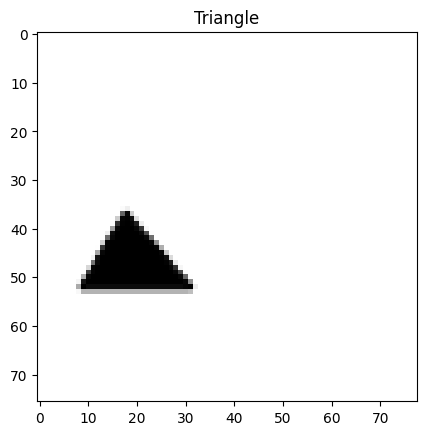

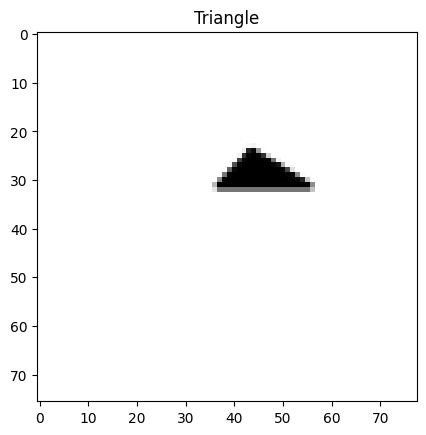

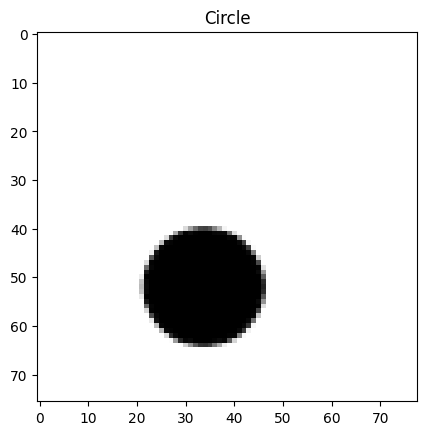

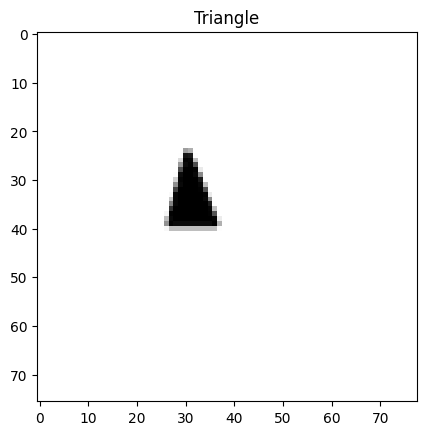

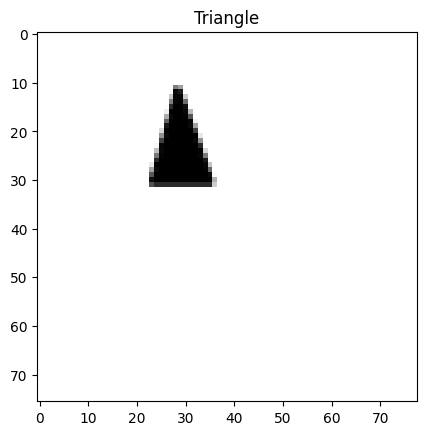

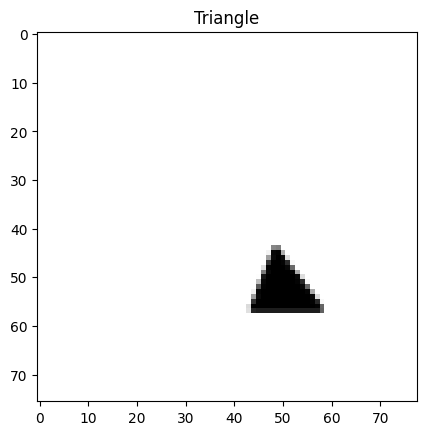

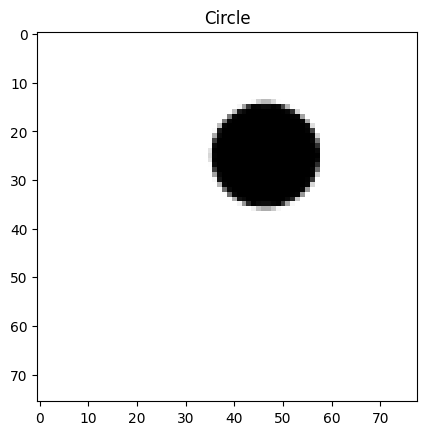

In [5]:
for iter_, (image, label) in enumerate(zip(X, y)):
    plt.imshow(image[:, :, 0], cmap='gray')
    plt.title('Triangle' if label == 1 else 'Circle')
    plt.show()
    
    if iter_ > 5:
        break

How many classes are we going to predict?

In [6]:
np.unique(y, return_counts=True)

(array([0, 1]), array([100, 100]))

- we have only two categories: Triangle (1) and Circle (0).


- hence, it's a binary classification and we will need only one single neuron in the predictive layer.

# Kernels and Convolutions

The following function __compute_convolution__ performs a __convolution operation__ <=> i.e. it applies a kernel to an image.

In [7]:
def compute_convolution(input_image, kernel):
    # Parameters
    kernel = np.array(kernel)
    kernel_height, kernel_width = kernel.shape

    img = np.squeeze(input_image) # Removes dimensions of size 1
    img_height, img_width = img.shape
    
    output_image = []

    for x in range(img_height - kernel_height + 1):
        arr = []
        
        for y in range(img_width - kernel_width + 1):
            
            a = np.multiply(img[x: x + kernel_height, y: y + kernel_width],
                            kernel)
            arr.append(a.sum())
            
        output_image.append(arr)
        
    return output_image

How does the __compute_convolution__ function work in practice?

1. Choose any image from the input dataset
2. Apply the __identity_kernel__ to it
3. Display both the input image and the output image.

In [8]:
identity_kernel = [
    [0, 0, 0],
    [0, 1, 0],
    [0, 0, 0]
]

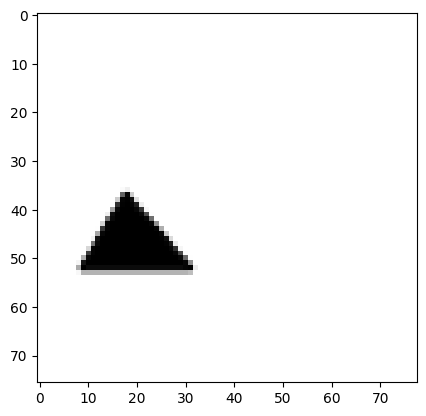

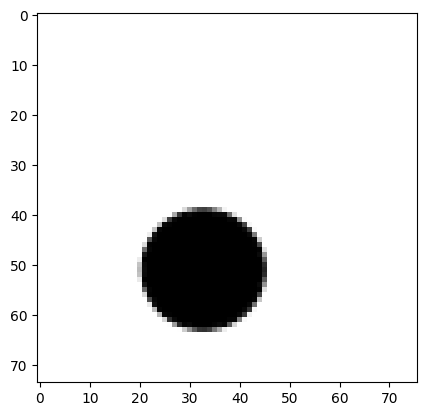

In [9]:
input_image = X[2]
kernel = identity_kernel

output_image = compute_convolution(input_image, kernel)

# Original Image
plt.imshow(np.squeeze(X[0]), cmap='gray')
plt.show()

# Convoluted image
plt.imshow(output_image, cmap='gray')
plt.show()

- The previous kernel corresponds to the __identity_kernel__, meaning that the output is equal to the input.


- It basically did nothing to the input image. If we think about it thoroughly, that's not surprising. With this kernel, only the pixel scanned in the middle, only the pixel scanned in the middle was kept and multiplied by one, the surrounding pixels were multiplied by zero

In [10]:
def plot_convolution(img, kernel, activation=False):
    ''' The following printing function ease the visualization'''
    
    img = np.squeeze(img)
    output_img = compute_convolution(img, kernel)
    if activation:
        output_img = np.maximum(output_img, 0)
    
    plt.figure(figsize=(10, 5))
    
    ax1 = plt.subplot2grid((3,3),(0,0), rowspan=3)
    ax1.imshow(img, cmap='gray')
    ax1.title.set_text('Input image')
    
    ax2 = plt.subplot2grid((3,3),(1, 1))
    ax2.imshow(kernel, cmap='gray')
    ax2.title.set_text('Kernel')    
    
    ax3 = plt.subplot2grid((3,3),(0, 2), rowspan=3)
    ax3.imshow(output_img, cmap='gray')
    ax3.title.set_text('Output image')    

    for ax in [ax1, ax2, ax3]:
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        
    plt.show()

In [11]:
kernel_1 = [
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
]

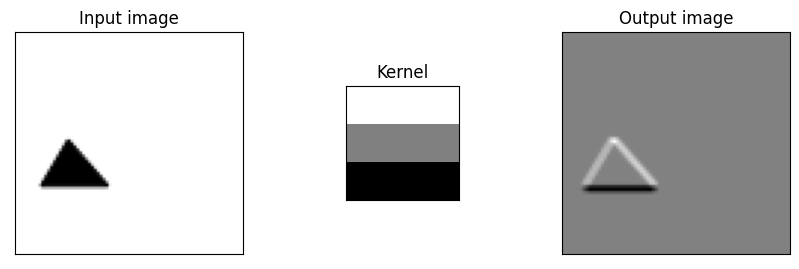

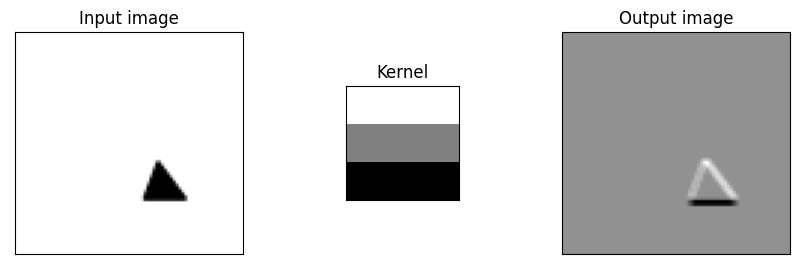

In [12]:
plot_convolution(X[0], kernel_1)
plot_convolution(X[5], kernel_1)

- White pixels correspond to high values and black pixels to low values


- In a Neural Network, we use activation functions to remove linearities:
    - for example, when the activation function is 'relu', we already know that it simply corresponds to setting the negative values to 0.

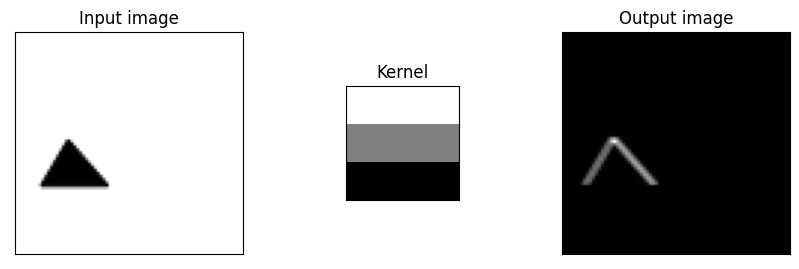

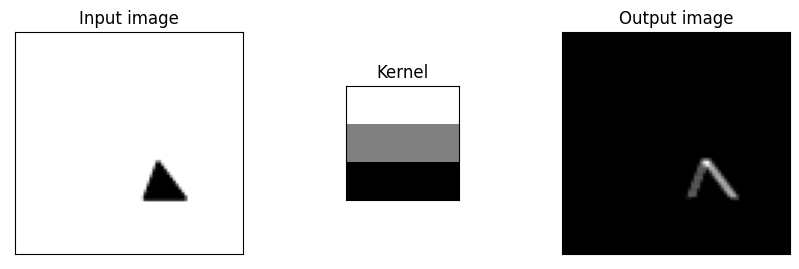

In [13]:
plot_convolution(X[0], kernel_1, activation=True)
plot_convolution(X[5], kernel_1, activation=True)

- this kernel is actually highlighting the edges in a given direction

In [14]:
kernel_2 = [
    [-1, -1, -1],
    [0, 0, 0],   
    [1, 1, 1],
]

kernel_3 = [
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]
]

kernel_4 = [
    [1, 0, -1],
    [1, 0, -1],
    [1, 0, -1]
]

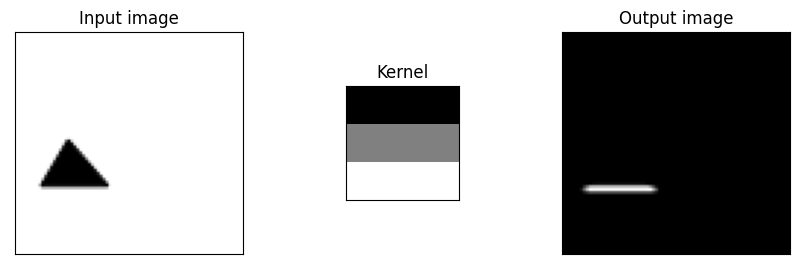

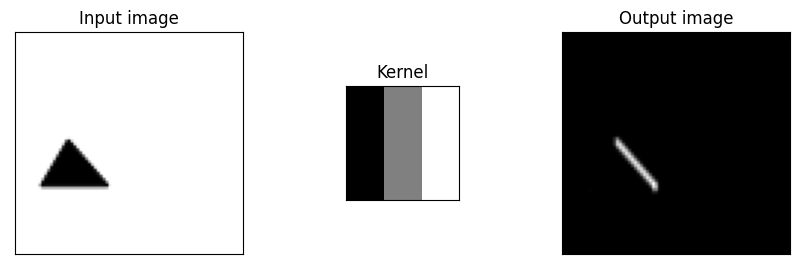

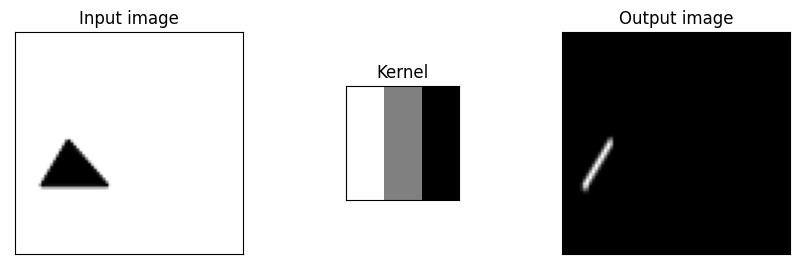

In [15]:
plot_convolution(X[0], kernel_2, activation=True)
plot_convolution(X[0], kernel_3, activation=True)
plot_convolution(X[0], kernel_4, activation=True)

In [16]:
kernel_big = np.array([
    np.ones((10,)),
    np.ones((10,)),
    np.ones((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.zeros((10,)),
    np.ones((10,))*-1,
    np.ones((10,))*-1,
    np.ones((10,))*-1,
])

kernel_big

array([[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.],
       [-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]])

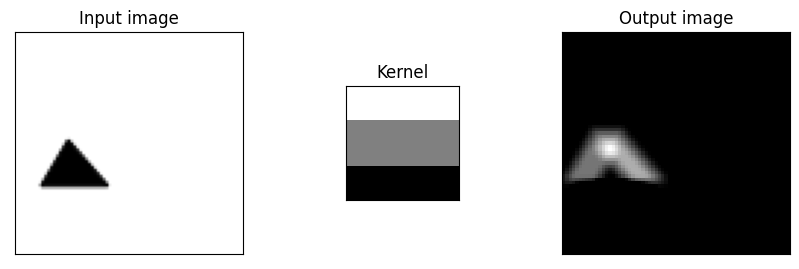

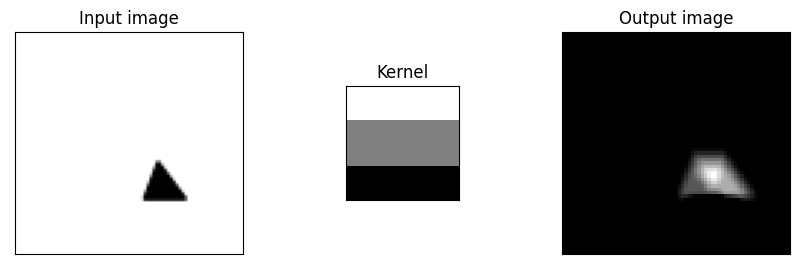

In [17]:
plot_convolution(X[0], kernel_big, activation=True)
plot_convolution(X[5], kernel_big, activation=True)

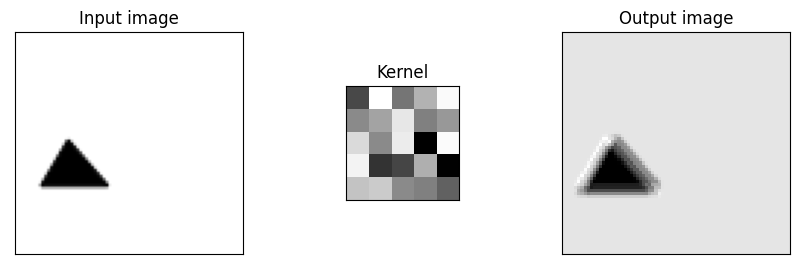

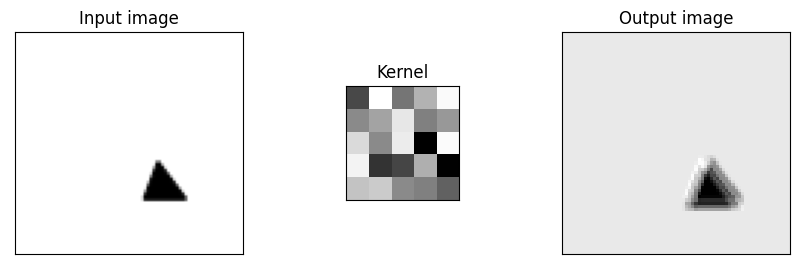

In [18]:
random_kernel = np.random.uniform(-10, 10, (5, 5))

plot_convolution(X[0], random_kernel, activation=True)
plot_convolution(X[5], random_kernel, activation=True)

Now we get the idea of what a convolution operation does to an image. Let's see how it goes with a 'real' Convolutional Neural Network

# Train a CNN to detect triangles and circles

## Architecture

In [19]:
X.shape

(200, 76, 78, 1)

In [20]:
from tensorflow.keras import layers, models

def initialize_model():
    
    model = models.Sequential()
    
    # first conv layer
    model.add(layers.Conv2D(16, (4,4), input_shape=(76,78,1), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    # second conv layer
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    # third conv layer
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    # fourth conv layer
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    
    # flatten layer
    model.add(layers.Flatten())
    
    # predictive layer
    model.add(layers.Dense(10, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # model compilation
    model.compile(loss='binary_crossentropy',
                 optimizer='adam',
                 metrics=['accuracy'])
    
    return model

2024-03-01 10:33:44.963486: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-01 10:33:45.337023: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-01 10:33:45.337046: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-01 10:33:45.394317: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-01 10:33:46.477454: W tensorflow/stream_executor/platform/de

In [21]:
model = initialize_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 75, 16)        272       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 37, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 35, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 64)         0

2024-03-01 10:33:47.657391: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-01 10:33:47.657756: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-01 10:33:47.657791: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (PORT-EMONTEIRO): /proc/driver/nvidia/version does not exist
2024-03-01 10:33:47.658835: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
# parameters on the 1 conv layer
((4*4)*1+1)*16

272

In [23]:
# parameters on 2 conv layer
((3*3)*16+1)*32

4640

In [24]:
# parameters on 3 conv layer
((3*3)*32+1)*64

18496

In [25]:
# parameters on 4 conv layer
((3*3)*64+1)*64

36928

# Trainning the CNN

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=5, restore_best_weights=True)

model = initialize_model()

history = model.fit(X, y,
                   validation_split=0.3,
                   batch_size=16,
                   epochs=50,
                   callbacks=[es],
                   verbose=1)

Epoch 1/50
9/9 [==============================] - 1s 42ms/step - loss: 0.6857 - accuracy: 0.5714 - val_loss: 0.7335 - val_accuracy: 0.3667
Epoch 2/50
9/9 [==============================] - 0s 20ms/step - loss: 0.6478 - accuracy: 0.6857 - val_loss: 0.6667 - val_accuracy: 0.5500
Epoch 3/50
9/9 [==============================] - 0s 18ms/step - loss: 0.5619 - accuracy: 0.7786 - val_loss: 0.6398 - val_accuracy: 0.5667
Epoch 4/50
9/9 [==============================] - 0s 19ms/step - loss: 0.3658 - accuracy: 0.8714 - val_loss: 0.4137 - val_accuracy: 0.8667
Epoch 5/50
9/9 [==============================] - 0s 18ms/step - loss: 0.2595 - accuracy: 0.9000 - val_loss: 0.3125 - val_accuracy: 0.8833
Epoch 6/50
9/9 [==============================] - 0s 18ms/step - loss: 0.1720 - accuracy: 0.9429 - val_loss: 0.2758 - val_accuracy: 0.8833
Epoch 7/50
9/9 [==============================] - 0s 18ms/step - loss: 0.1296 - accuracy: 0.9571 - val_loss: 0.2322 - val_accuracy: 0.9167
Epoch 8/50
9/9 [===========

In [27]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylim((0,3))
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].set_ylim((0,1))
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

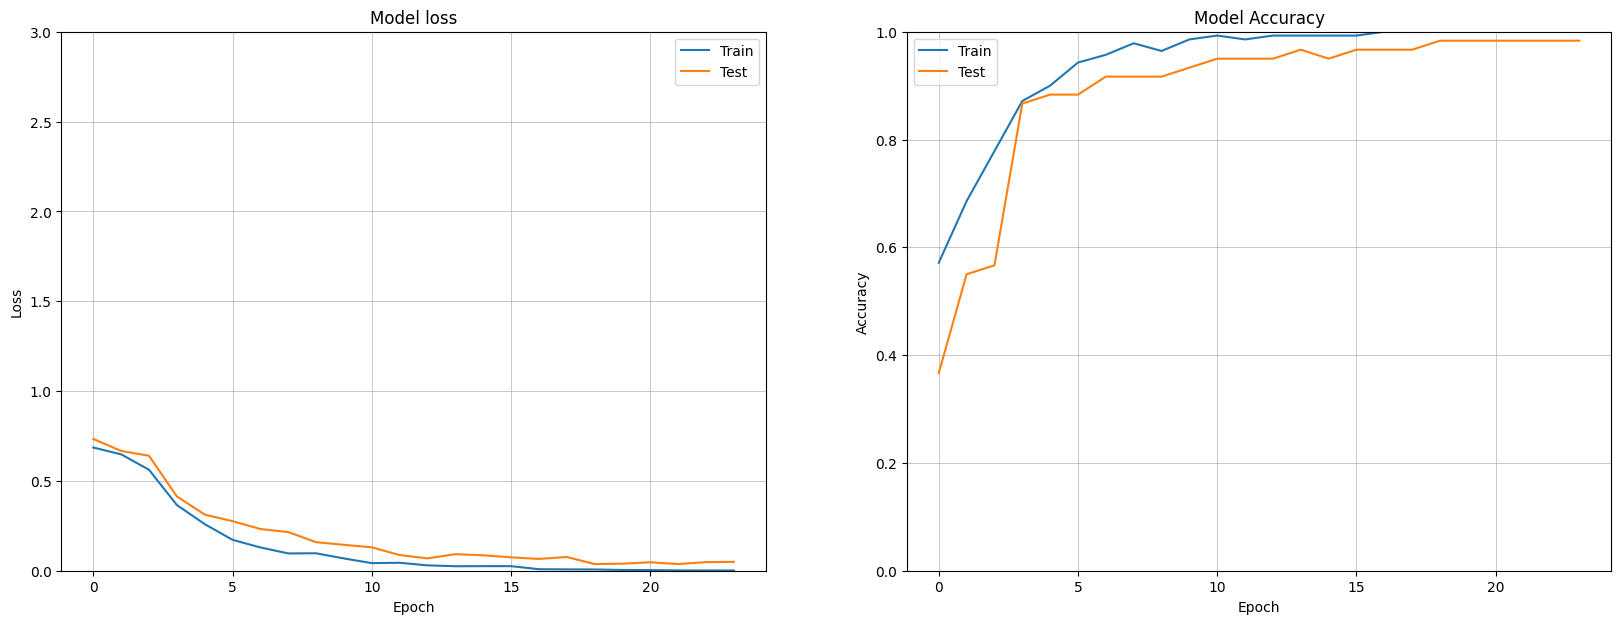

In [28]:
plot_loss_accuracy(history)